# Damage Localization using AR and ARX Models

This notebook demonstrates damage localization techniques using autoregressive (AR) and autoregressive with exogenous inputs (ARX) model parameters from an array of sensors. The example compares the effectiveness of AR vs ARX models for identifying and localizing structural damage.

## Overview

The goal is to locate the source of damage in a structure based on outlier/novelty detection. We extract AR and ARX parameters as damage-sensitive features and use the Mahalanobis distance to create damage indicators (DIs) that are invariant for normal conditions but increase for damaged conditions.

### Key Concepts:

1. **AR Model**: Output-only model that captures the system's dynamic behavior
2. **ARX Model**: Input-output model that incorporates force measurements
3. **Damage Localization**: Identifying which sensors are closest to damage
4. **Mahalanobis Distance**: Statistical measure for outlier detection

### Dataset:

We use the 3-story structure dataset with:
- 5 channels: 1 input force + 4 output accelerations
- 170 conditions: 90 undamaged + 80 damaged (17 states × 10 tests each)
- Damage is located near channels 4 and 5

### References
- Figueiredo, E., Park, G., Figueiras, J., Farrar, C., & Worden, K. (2009). Structural Health Monitoring Algorithm Comparisons using Standard Data Sets. Los Alamos National Laboratory Report: LA-14393.

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import shmtools (installed package)
from examples.data import import_3story_structure_shm
from shmtools.features import ar_model_shm, arx_model_shm
from shmtools.classification import learn_mahalanobis_shm, score_mahalanobis_shm

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Helper Functions

Define helper functions for damage localization analysis and visualization.

In [2]:
def compute_channel_wise_damage_indicators(features, states, undamaged_states, 
                                         n_channels, features_per_channel, method='mahalanobis'):
    """
    Compute damage indicators for each channel separately.
    
    Parameters
    ----------
    features : ndarray
        Feature matrix (n_instances, n_features)
    states : ndarray
        State labels for each instance
    undamaged_states : list
        List of state numbers considered undamaged
    n_channels : int
        Number of channels
    features_per_channel : int
        Number of features per channel
    method : str
        Method for computing damage indicators ('mahalanobis')
        
    Returns
    -------
    damage_indicators : ndarray
        Damage indicators for each state and channel (n_states, n_channels)
    models : list
        List of trained models for each channel
    """
    # Get unique states and sort them
    unique_states = np.unique(states)
    n_states = len(unique_states)
    
    # Initialize output arrays
    damage_indicators = np.zeros((n_states, n_channels))
    models = []
    
    # Process each channel separately
    for ch in range(n_channels):
        # Extract features for this channel
        start_idx = ch * features_per_channel
        end_idx = (ch + 1) * features_per_channel
        channel_features = features[:, start_idx:end_idx]
        
        # Get undamaged data for training
        undamaged_mask = np.isin(states, undamaged_states)
        undamaged_features = channel_features[undamaged_mask, :]
        
        # Train model on undamaged data
        if method == 'mahalanobis':
            model = learn_mahalanobis_shm(undamaged_features)
        else:
            raise ValueError(f"Unsupported method: {method}")
            
        models.append(model)
        
        # Compute damage indicators for all states
        for i, state in enumerate(unique_states):
            # Get features for this state
            state_mask = states == state
            state_features = channel_features[state_mask, :]
            
            # Compute mean damage indicator for this state
            if method == 'mahalanobis':
                # Ensure state_features is 2D
                if state_features.ndim == 1:
                    state_features = state_features.reshape(1, -1)
                scores = score_mahalanobis_shm(state_features, model)
                # Make damage indicators positive (following MATLAB convention: DI = -DI)
                # More positive values indicate more damage
                damage_indicators[i, ch] = -np.mean(scores)
    
    return damage_indicators, models


def plot_damage_indicators(damage_indicators, channel_names, state_labels, 
                          undamaged_states, title="Damage Indicators"):
    """
    Plot damage indicators for multiple channels.
    
    Parameters
    ----------
    damage_indicators : ndarray
        Damage indicators (n_states, n_channels)
    channel_names : list
        List of channel names
    state_labels : ndarray
        State labels for x-axis
    undamaged_states : list
        Indices of undamaged states for coloring
    title : str
        Plot title
    """
    n_channels = len(channel_names)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for ch in range(n_channels):
        ax = axes[ch]
        
        # Create separate bars for undamaged and damaged states
        undamaged_bars = []
        damaged_bars = []
        
        for i, state_idx in enumerate(range(len(damage_indicators))):
            if i in undamaged_states:
                undamaged_bars.append((i, damage_indicators[state_idx, ch]))
            else:
                damaged_bars.append((i, damage_indicators[state_idx, ch]))
        
        # Plot undamaged bars in black
        if undamaged_bars:
            undamaged_x, undamaged_y = zip(*undamaged_bars)
            ax.bar(undamaged_x, undamaged_y, color='k', alpha=0.7, label='Undamaged')
        
        # Plot damaged bars in red  
        if damaged_bars:
            damaged_x, damaged_y = zip(*damaged_bars)
            ax.bar(damaged_x, damaged_y, color='r', alpha=0.7, label='Damaged')
        
        ax.set_title(f'{channel_names[ch]}', fontsize=12)
        ax.set_xlim(-0.5, len(damage_indicators) - 0.5)
        ax.set_xticks(range(len(damage_indicators)))
        ax.set_xticklabels(state_labels)
        ax.set_xlabel('State Condition')
        ax.set_ylabel('Damage Indicator')
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first subplot (to avoid duplicates)
        if ch == 0:
            ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()


def analyze_damage_localization(damage_indicators, channel_names, undamaged_states):
    """
    Analyze damage localization results.
    
    Parameters
    ----------
    damage_indicators : ndarray
        Damage indicators (n_states, n_channels)
    channel_names : list
        List of channel names
    undamaged_states : list
        Indices of undamaged states
        
    Returns
    -------
    dict
        Analysis results including sensitivity and ranking
    """
    n_states, n_channels = damage_indicators.shape
    
    # Calculate channel sensitivity (mean DI for damaged states)
    damaged_states = [i for i in range(n_states) if i not in undamaged_states]
    channel_sensitivity = np.mean(damage_indicators[damaged_states, :], axis=0)
    
    # Rank channels by sensitivity (most sensitive first)
    damage_ranking = np.argsort(channel_sensitivity)[::-1]
    
    # Create interpretation
    most_sensitive = channel_names[damage_ranking[0]]
    least_sensitive = channel_names[damage_ranking[-1]]
    
    interpretation = f"""
Channel sensitivity ranking (most to least sensitive to damage):
{', '.join([f"{i+1}. {channel_names[idx]} ({channel_sensitivity[idx]:.3f})" 
           for i, idx in enumerate(damage_ranking)])}

Analysis:
- Most damage-sensitive: {most_sensitive} (closest to damage)
- Least damage-sensitive: {least_sensitive} (furthest from damage)
- This suggests damage is located closest to {most_sensitive}
""".strip()
    
    return {
        'channel_sensitivity': channel_sensitivity,
        'damage_ranking': damage_ranking,
        'interpretation': interpretation
    }


def compare_ar_arx_localization(ar_indicators, arx_indicators, channel_names, undamaged_states):
    """
    Compare AR and ARX damage localization results.
    
    Parameters
    ----------
    ar_indicators : ndarray
        AR method damage indicators
    arx_indicators : ndarray
        ARX method damage indicators  
    channel_names : list
        List of channel names
    undamaged_states : list
        Indices of undamaged states
        
    Returns
    -------
    dict
        Comparison results
    """
    # Get sensitivity for damaged states
    n_states = len(ar_indicators)
    damaged_states = [i for i in range(n_states) if i not in undamaged_states]
    
    ar_sensitivity = np.mean(ar_indicators[damaged_states, :], axis=0)
    arx_sensitivity = np.mean(arx_indicators[damaged_states, :], axis=0)
    
    # Calculate improvement ratio
    sensitivity_ratio = arx_sensitivity / ar_sensitivity
    
    # Determine which method is better overall
    overall_improvement = np.mean(sensitivity_ratio)
    
    if overall_improvement > 1.1:
        winner = "ARX method shows superior damage localization"
    elif overall_improvement < 0.9:
        winner = "AR method shows superior damage localization"
    else:
        winner = "Both methods show comparable performance"
    
    summary = f"""
METHOD COMPARISON SUMMARY:
- {winner}
- Overall sensitivity ratio (ARX/AR): {overall_improvement:.2f}×

Channel-wise improvements:
{chr(10).join([f"  {channel_names[i]}: {sensitivity_ratio[i]:.2f}× {'(improved)' if sensitivity_ratio[i] > 1 else '(degraded)'}" 
               for i in range(len(channel_names))])}

Recommendation:
{'Use ARX method for better damage sensitivity and localization.' if overall_improvement > 1.05 
 else 'Use AR method for simplicity; ARX does not provide significant improvement.' if overall_improvement < 0.95
 else 'Either method can be used; consider implementation complexity and available measurements.'}
""".strip()
    
    return {
        'ar_sensitivity': ar_sensitivity,
        'arx_sensitivity': arx_sensitivity,
        'sensitivity_ratio': sensitivity_ratio,
        'overall_improvement': overall_improvement,
        'summary': summary
    }

print("Helper functions defined successfully.")

Helper functions defined successfully.


## Load Data

Load the 3-story structure dataset. This dataset contains time series data from a base-excited three-story structure with various damage conditions.

In [3]:
# Load the 3-story structure dataset
try:
    dataset, damage_states, state_list = import_3story_structure_shm()
    states = state_list.flatten().astype(int)
    
    print(f"Dataset shape: {dataset.shape}")
    print(f"Shape explanation: ({dataset.shape[0]} time points, {dataset.shape[1]} channels, {dataset.shape[2]} instances)")
    print(f"\nChannels:")
    
    # Use default channel names
    channels = ['Force', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5']
    for i, ch in enumerate(channels):
        print(f"  Channel {i+1}: {ch}")
        
    print(f"\nDamage states: {np.unique(states)}")
    print(f"Instances per state: {np.sum(states == 1)}")
    print(f"Total instances: {len(states)}")
    
    # Verify data structure
    print(f"\nData verification:")
    print(f"- States 1-9: Undamaged conditions ({np.sum(states <= 9)} instances)")
    print(f"- States 10-17: Damaged conditions ({np.sum(states > 9)} instances)")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("\nPlease download the example datasets following the instructions in:")
    print("examples/data/README.md")
    raise

Dataset shape: (8192, 5, 170)
Shape explanation: (8192 time points, 5 channels, 170 instances)

Channels:
  Channel 1: Force
  Channel 2: Channel 2
  Channel 3: Channel 3
  Channel 4: Channel 4
  Channel 5: Channel 5

Damage states: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Instances per state: 10
Total instances: 170

Data verification:
- States 1-9: Undamaged conditions (90 instances)
- States 10-17: Damaged conditions (80 instances)


## Plot Sample Time Histories

Let's visualize the time histories from the baseline condition to understand the data structure.

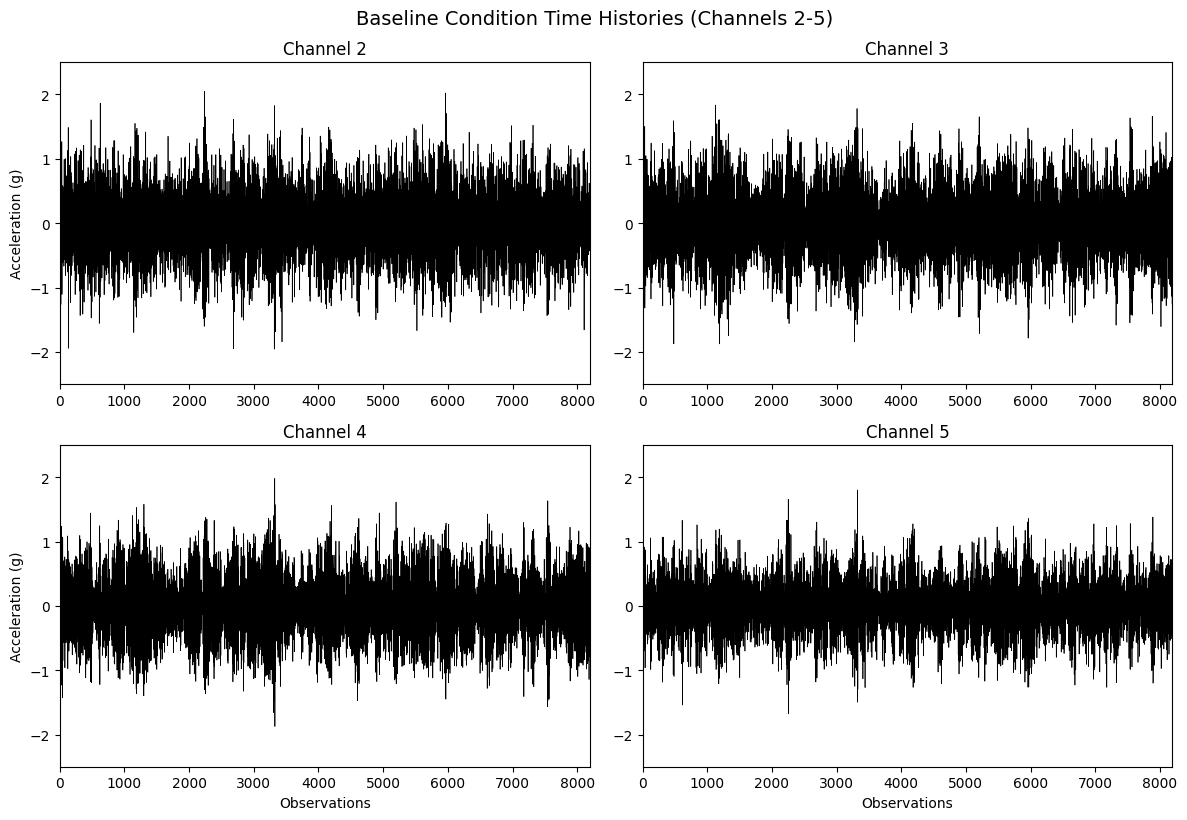

In [4]:
# Plot time histories from baseline condition (channels 2-5)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i in range(4):
    channel_data = dataset[:, i+1, 0]  # Channel i+2, first instance
    axes[i].plot(channel_data, 'k', linewidth=0.5)
    axes[i].set_title(f'Channel {i+2}')
    axes[i].set_xlim(0, dataset.shape[0])
    axes[i].set_ylim(-2.5, 2.5)
    axes[i].set_yticks([-2, -1, 0, 1, 2])
    
    if i >= 2:
        axes[i].set_xlabel('Observations')
    if i % 2 == 0:
        axes[i].set_ylabel('Acceleration (g)')

plt.tight_layout()
plt.suptitle('Baseline Condition Time Histories (Channels 2-5)', fontsize=14, y=1.02)
plt.show()

## Part 1: Damage Localization using AR Parameters

First, we'll use the traditional AR model approach, which only uses the output acceleration measurements (channels 2-5).

In [5]:
# Extract AR(15) parameters from channels 2-5
ar_order = 15
output_data = dataset[:, 1:5, :]  # Channels 2-5 only

print(f"AR data shape: {output_data.shape}")
print(f"Estimating AR({ar_order}) parameters...")

ar_params_fv, ar_rms_fv, ar_params, _, _ = ar_model_shm(output_data, ar_order)

print(f"\nAR parameters shape: {ar_params_fv.shape}")
print(f"Shape explanation: ({ar_params_fv.shape[0]} instances, {ar_params_fv.shape[1]} features)")
print(f"Features per channel: {ar_order}")
print(f"Total features: {4} channels × {ar_order} parameters = {ar_params_fv.shape[1]}")

AR data shape: (8192, 4, 170)
Estimating AR(15) parameters...


/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: divide by zero encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: overflow encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: invalid value encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.


AR parameters shape: (170, 60)
Shape explanation: (170 instances, 60 features)
Features per channel: 15
Total features: 4 channels × 15 parameters = 60


### Visualize AR Parameters

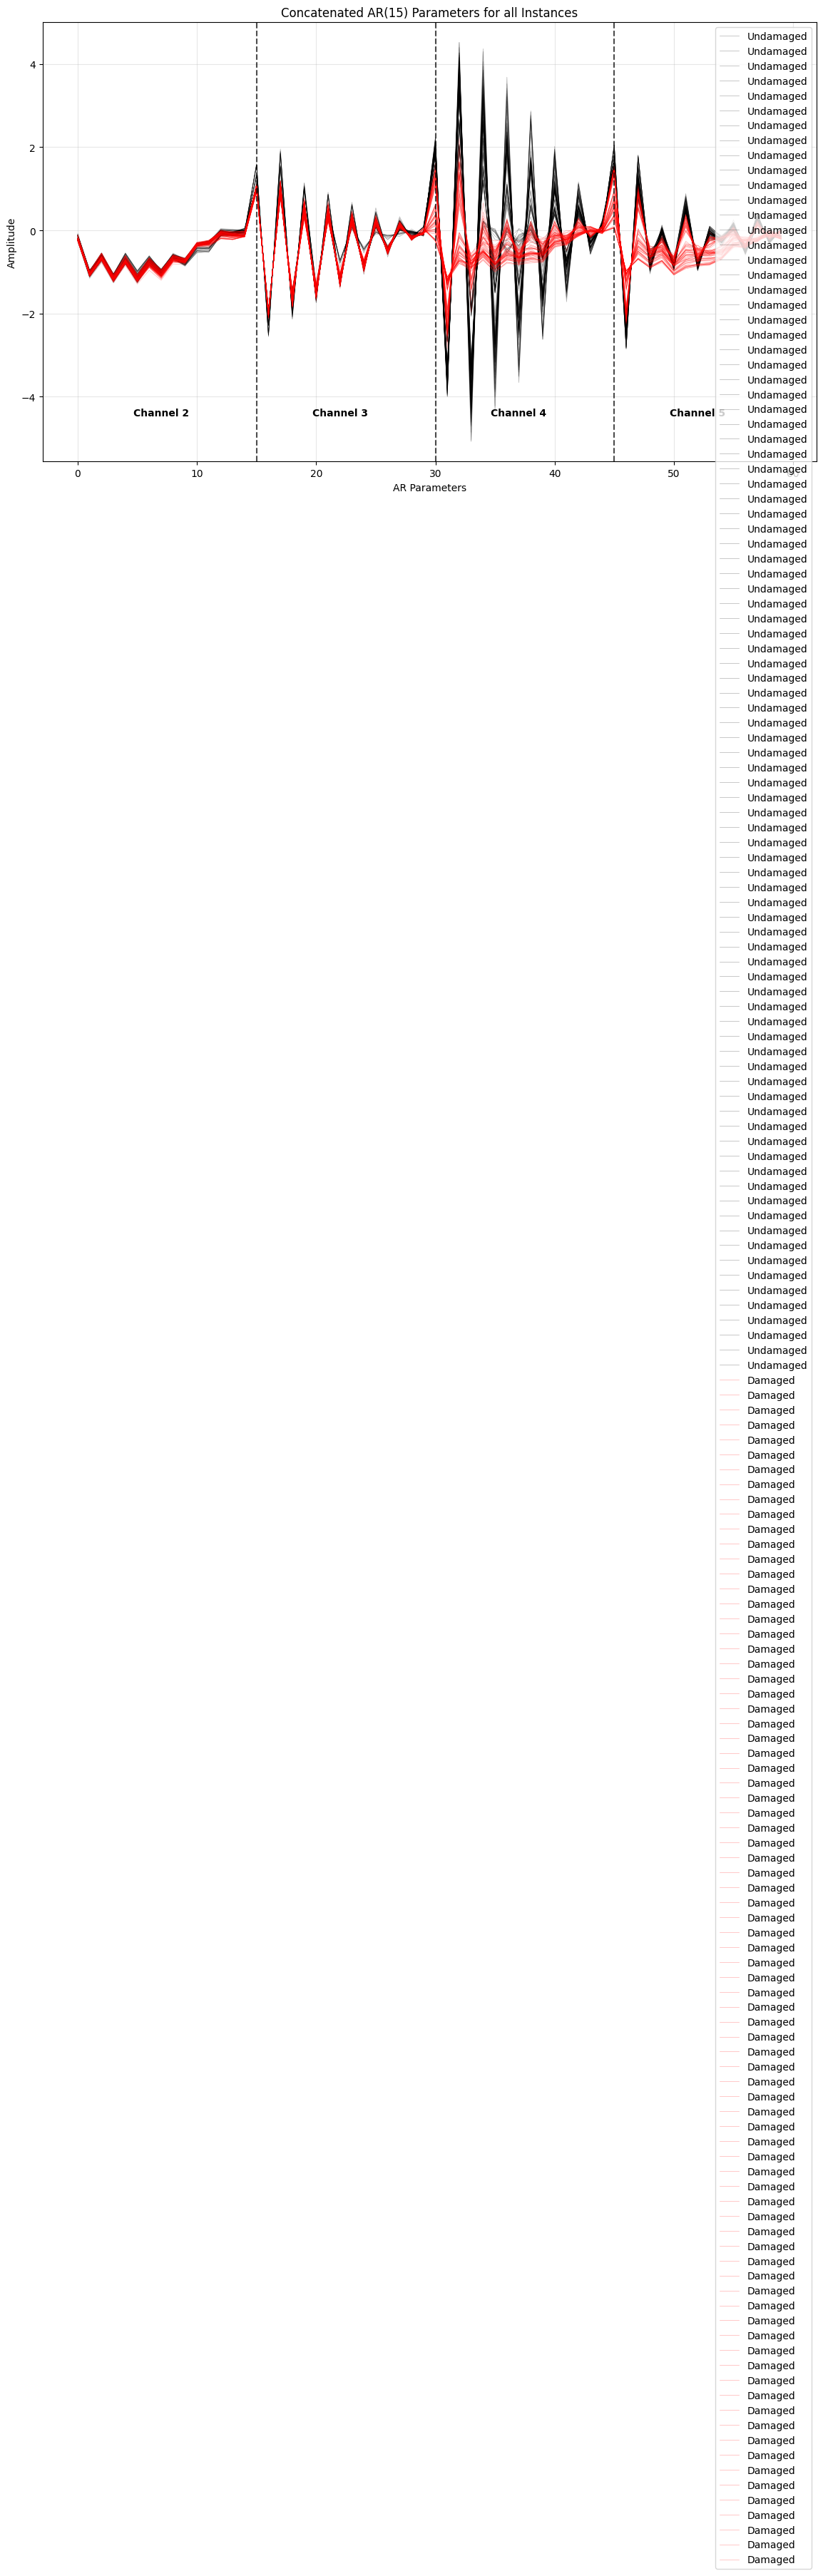

In [6]:
# Plot AR parameters for all instances
plt.figure(figsize=(14, 8))

# Separate undamaged (1-90) and damaged (91-170) instances
undamaged_mask = states <= 9
damaged_mask = states > 9

# Plot undamaged in black, damaged in red
plt.plot(ar_params_fv[undamaged_mask, :].T, 'k-', alpha=0.3, linewidth=0.5, label='Undamaged')
plt.plot(ar_params_fv[damaged_mask, :].T, 'r-', alpha=0.3, linewidth=0.5, label='Damaged')

# Add channel separators
for i in range(1, 4):
    plt.axvline(i * ar_order, color='k', linestyle='--', alpha=0.7)

# Add channel labels
channel_positions = [ar_order//2 + i*ar_order for i in range(4)]
channel_labels = ['Channel 2', 'Channel 3', 'Channel 4', 'Channel 5']
for pos, label in zip(channel_positions, channel_labels):
    plt.text(pos, plt.ylim()[0] + 0.1*(plt.ylim()[1] - plt.ylim()[0]), 
             label, ha='center', va='bottom', fontweight='bold')

plt.xlabel('AR Parameters')
plt.ylabel('Amplitude')
plt.title(f'Concatenated AR({ar_order}) Parameters for all Instances')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

### Compute Channel-wise Damage Indicators (AR)

In [7]:
# Compute damage indicators for each channel using AR parameters
print("Computing channel-wise damage indicators using AR parameters...")

undamaged_states = list(range(1, 10))  # States 1-9
n_channels = 4
features_per_channel = ar_order

ar_damage_indicators, ar_models = compute_channel_wise_damage_indicators(
    ar_params_fv, 
    states,
    undamaged_states=undamaged_states,
    n_channels=n_channels,
    features_per_channel=features_per_channel,
    method='mahalanobis'
)

print(f"AR damage indicators shape: {ar_damage_indicators.shape}")
print(f"(states, channels) = ({ar_damage_indicators.shape[0]}, {ar_damage_indicators.shape[1]})")

Computing channel-wise damage indicators using AR parameters...
AR damage indicators shape: (17, 4)
(states, channels) = (17, 4)


### Plot AR Damage Indicators

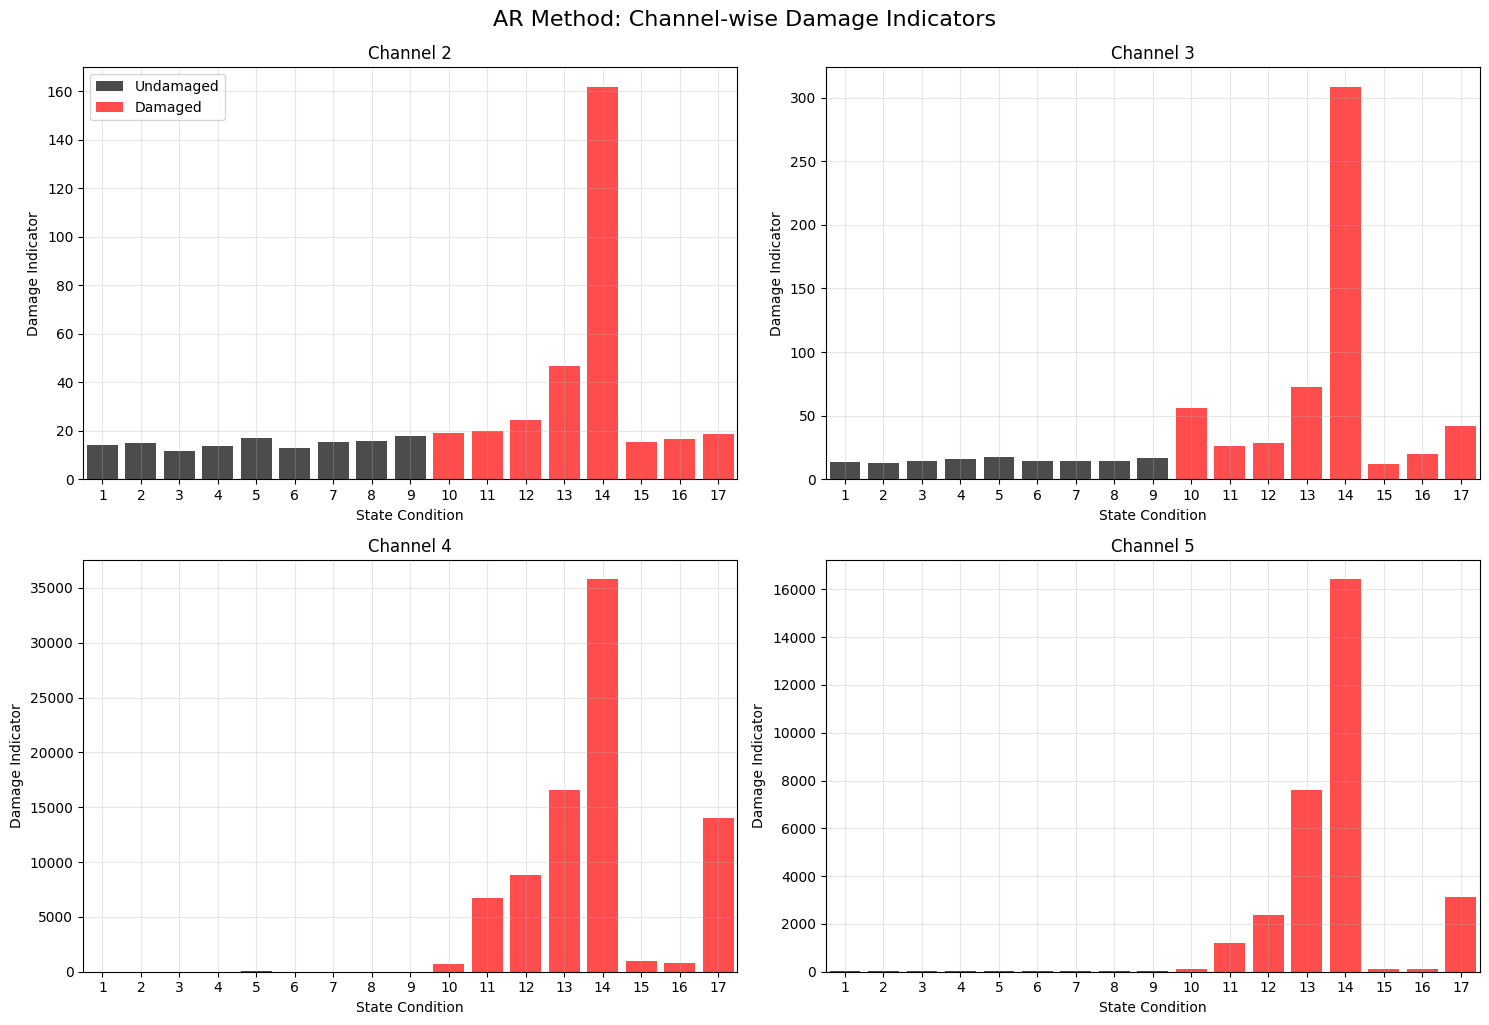

In [8]:
# Plot damage indicators for AR method
channel_names = ['Channel 2', 'Channel 3', 'Channel 4', 'Channel 5']
state_labels = np.arange(1, 18)
undamaged_indices = list(range(9))  # First 9 states

plot_damage_indicators(
    ar_damage_indicators,
    channel_names=channel_names,
    state_labels=state_labels,
    undamaged_states=undamaged_indices,
    title="AR Method: Channel-wise Damage Indicators"
)

## Part 2: Damage Localization using ARX Parameters

Now we'll use the ARX model, which incorporates the input force measurement (channel 1) along with the output accelerations.

In [9]:
# Extract ARX(10,5,0) parameters
arx_orders = [10, 5, 0]  # a=10 (output order), b=5 (input order), tau=0 (no delay)

print(f"ARX data shape: {dataset.shape}")
print(f"Estimating ARX({arx_orders[0]},{arx_orders[1]},{arx_orders[2]}) parameters...")

arx_params_fv, arx_rms_fv, arx_params, _, _, _ = arx_model_shm(dataset, arx_orders)
arx_features_per_channel = arx_orders[0] + arx_orders[1]  # a + b = 15

print(f"\nARX parameters shape: {arx_params_fv.shape}")
print(f"Shape explanation: ({arx_params_fv.shape[0]} instances, {arx_params_fv.shape[1]} features)")
print(f"Features per channel: {arx_features_per_channel} ({arx_orders[0]} AR + {arx_orders[1]} input terms)")
print(f"Total features: {4} channels × {arx_features_per_channel} parameters = {arx_params_fv.shape[1]}")

ARX data shape: (8192, 5, 170)
Estimating ARX(10,5,0) parameters...


/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/shmtools/features/time_series.py:618: RuntimeWarning: divide by zero encountered in matmul
  arx_param = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:618: RuntimeWarning: overflow encountered in matmul
  arx_param = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:618: RuntimeWarning: invalid value encountered in matmul
  arx_param = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:626: Runtime


ARX parameters shape: (170, 60)
Shape explanation: (170 instances, 60 features)
Features per channel: 15 (10 AR + 5 input terms)
Total features: 4 channels × 15 parameters = 60


### Visualize ARX Parameters

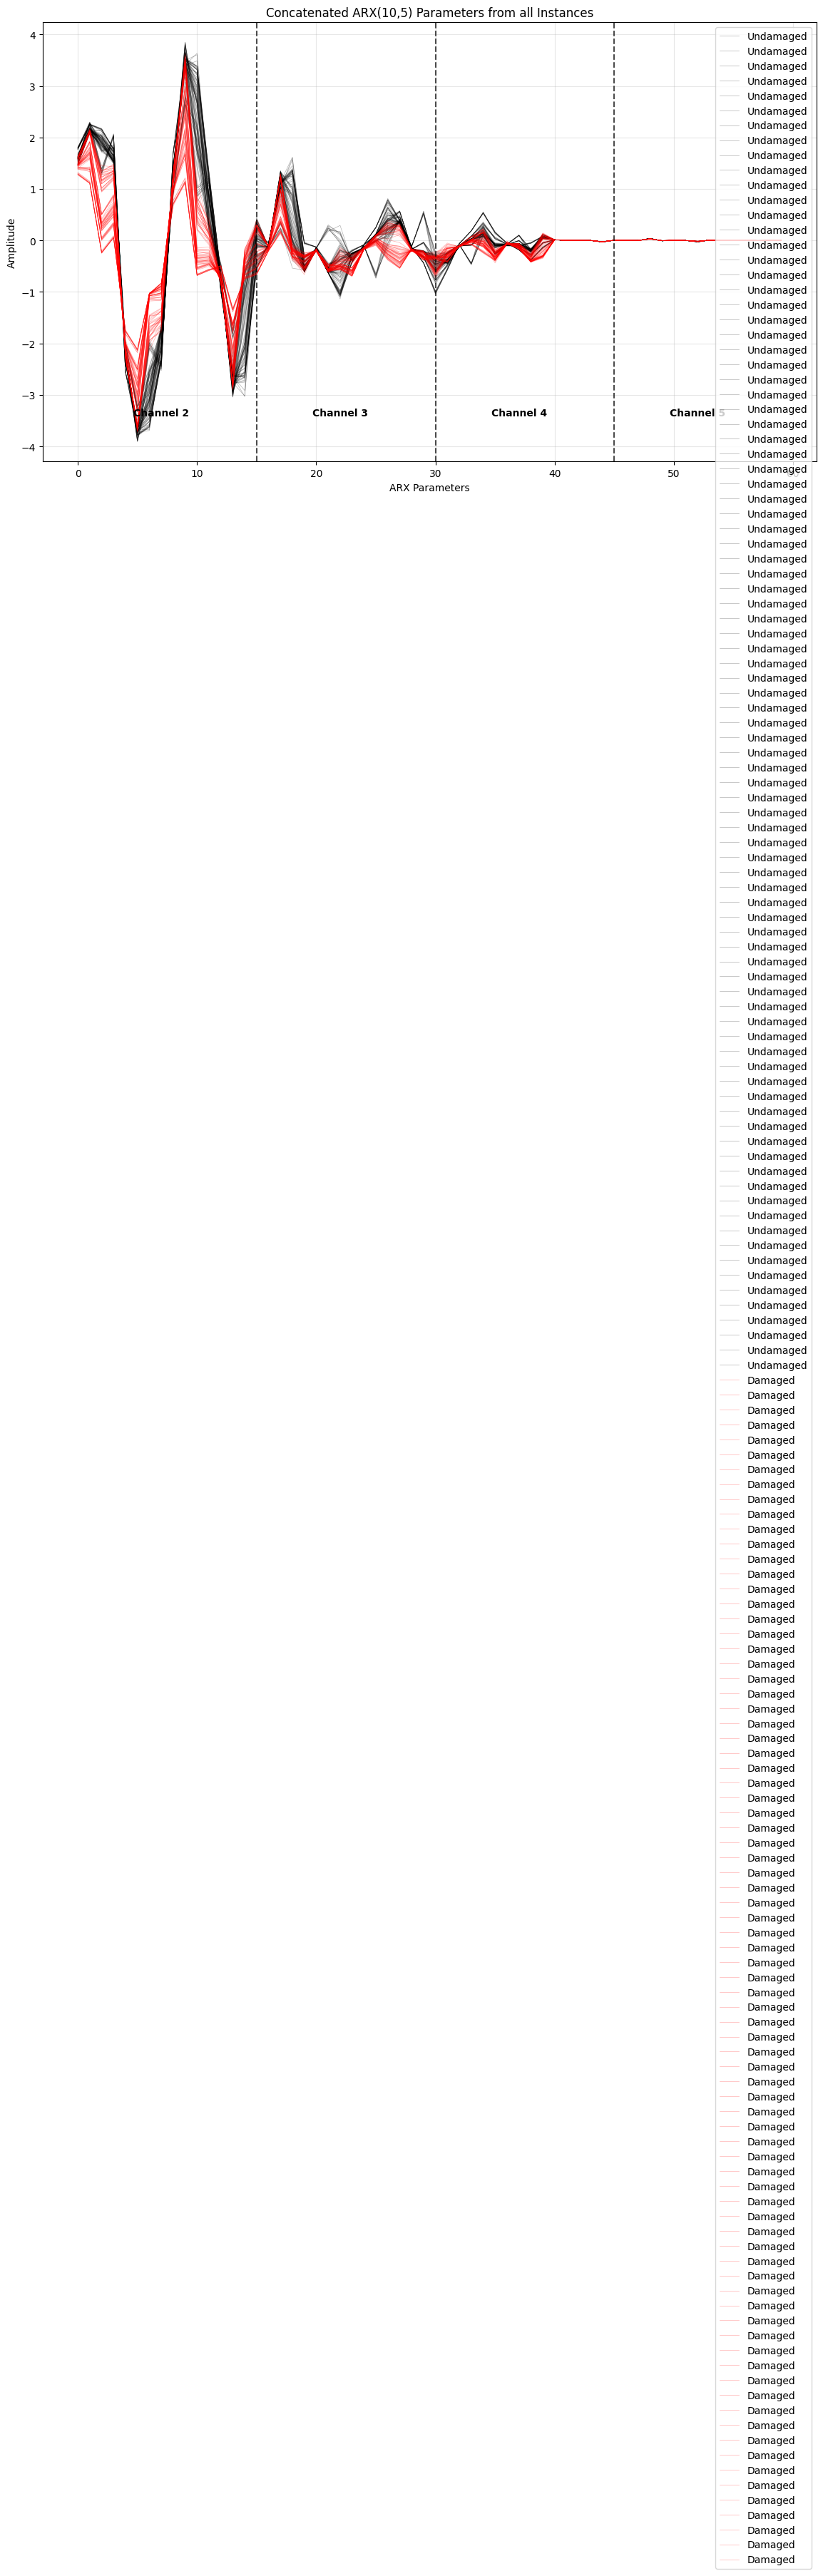

In [10]:
# Plot ARX parameters for all instances
plt.figure(figsize=(14, 8))

# Plot undamaged in black, damaged in red
plt.plot(arx_params_fv[undamaged_mask, :].T, 'k-', alpha=0.3, linewidth=0.5, label='Undamaged')
plt.plot(arx_params_fv[damaged_mask, :].T, 'r-', alpha=0.3, linewidth=0.5, label='Damaged')

# Add channel separators
for i in range(1, 4):
    plt.axvline(i * arx_features_per_channel, color='k', linestyle='--', alpha=0.7)

# Add channel labels
channel_positions = [arx_features_per_channel//2 + i*arx_features_per_channel for i in range(4)]
for pos, label in zip(channel_positions, channel_labels):
    plt.text(pos, plt.ylim()[0] + 0.1*(plt.ylim()[1] - plt.ylim()[0]), 
             label, ha='center', va='bottom', fontweight='bold')

plt.xlabel('ARX Parameters')
plt.ylabel('Amplitude')
plt.title(f'Concatenated ARX({arx_orders[0]},{arx_orders[1]}) Parameters from all Instances')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

### Compute Channel-wise Damage Indicators (ARX)

In [11]:
# Compute damage indicators for each channel using ARX parameters
print("Computing channel-wise damage indicators using ARX parameters...")

arx_damage_indicators, arx_models = compute_channel_wise_damage_indicators(
    arx_params_fv,
    states,
    undamaged_states=undamaged_states,
    n_channels=n_channels,
    features_per_channel=arx_features_per_channel,
    method='mahalanobis'
)

print(f"ARX damage indicators shape: {arx_damage_indicators.shape}")
print(f"(states, channels) = ({arx_damage_indicators.shape[0]}, {arx_damage_indicators.shape[1]})")

Computing channel-wise damage indicators using ARX parameters...
ARX damage indicators shape: (17, 4)
(states, channels) = (17, 4)


### Plot ARX Damage Indicators

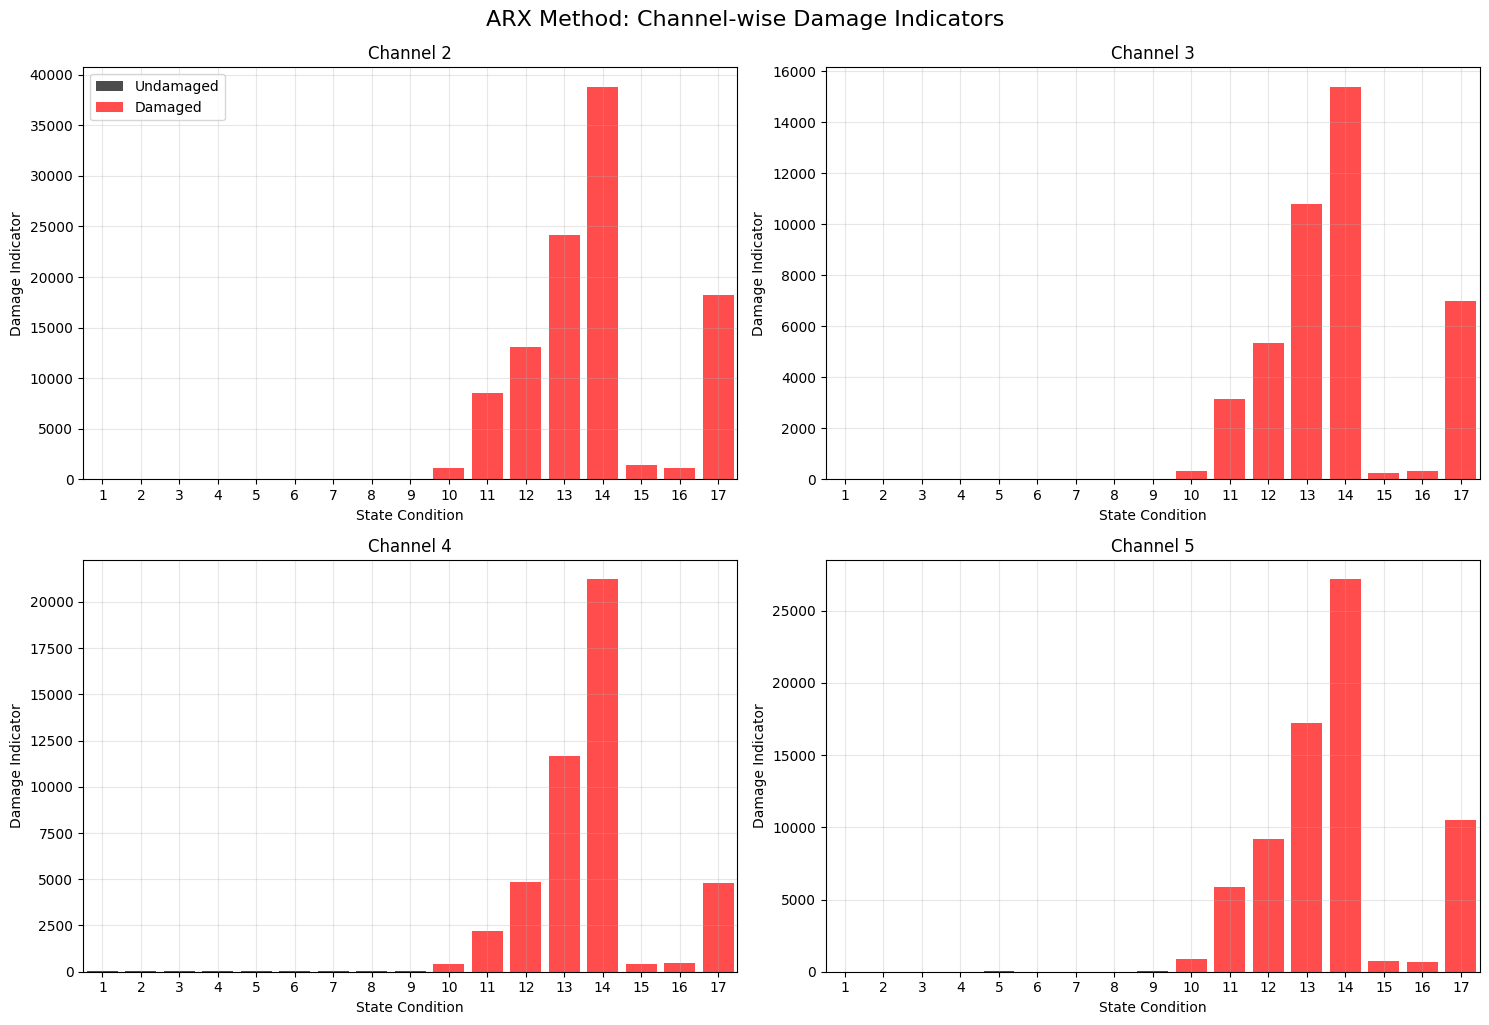

In [12]:
# Plot damage indicators for ARX method
plot_damage_indicators(
    arx_damage_indicators,
    channel_names=channel_names,
    state_labels=state_labels,
    undamaged_states=undamaged_indices,
    title="ARX Method: Channel-wise Damage Indicators"
)

## Analysis and Comparison

### AR Method Analysis

In [13]:
# Analyze AR method results
ar_analysis = analyze_damage_localization(
    ar_damage_indicators,
    channel_names=channel_names,
    undamaged_states=undamaged_indices
)

print("=" * 60)
print("AR METHOD DAMAGE LOCALIZATION ANALYSIS")
print("=" * 60)
print(ar_analysis['interpretation'])

# Show channel sensitivity ranking
print(f"\nChannel sensitivity values:")
for i, (channel, sensitivity) in enumerate(zip(channel_names, ar_analysis['channel_sensitivity'])):
    rank = np.where(ar_analysis['damage_ranking'] == i)[0][0] + 1
    print(f"  {channel}: {sensitivity:.3f} (rank {rank})")

AR METHOD DAMAGE LOCALIZATION ANALYSIS
Channel sensitivity ranking (most to least sensitive to damage):
1. Channel 4 (10557.055), 2. Channel 5 (3885.594), 3. Channel 3 (70.683), 4. Channel 2 (40.258)

Analysis:
- Most damage-sensitive: Channel 4 (closest to damage)
- Least damage-sensitive: Channel 2 (furthest from damage)
- This suggests damage is located closest to Channel 4

Channel sensitivity values:
  Channel 2: 40.258 (rank 4)
  Channel 3: 70.683 (rank 3)
  Channel 4: 10557.055 (rank 1)
  Channel 5: 3885.594 (rank 2)


### ARX Method Analysis

In [14]:
# Analyze ARX method results
arx_analysis = analyze_damage_localization(
    arx_damage_indicators,
    channel_names=channel_names,
    undamaged_states=undamaged_indices
)

print("=" * 60)
print("ARX METHOD DAMAGE LOCALIZATION ANALYSIS")
print("=" * 60)
print(arx_analysis['interpretation'])

# Show channel sensitivity ranking
print(f"\nChannel sensitivity values:")
for i, (channel, sensitivity) in enumerate(zip(channel_names, arx_analysis['channel_sensitivity'])):
    rank = np.where(arx_analysis['damage_ranking'] == i)[0][0] + 1
    print(f"  {channel}: {sensitivity:.3f} (rank {rank})")

ARX METHOD DAMAGE LOCALIZATION ANALYSIS
Channel sensitivity ranking (most to least sensitive to damage):
1. Channel 2 (13306.569), 2. Channel 5 (9015.490), 3. Channel 4 (5754.261), 4. Channel 3 (5319.531)

Analysis:
- Most damage-sensitive: Channel 2 (closest to damage)
- Least damage-sensitive: Channel 3 (furthest from damage)
- This suggests damage is located closest to Channel 2

Channel sensitivity values:
  Channel 2: 13306.569 (rank 1)
  Channel 3: 5319.531 (rank 4)
  Channel 4: 5754.261 (rank 3)
  Channel 5: 9015.490 (rank 2)


### AR vs ARX Comparison

In [15]:
# Compare AR and ARX methods
comparison = compare_ar_arx_localization(
    ar_damage_indicators,
    arx_damage_indicators,
    channel_names=channel_names,
    undamaged_states=undamaged_indices
)

print("=" * 60)
print("AR vs ARX COMPARISON")
print("=" * 60)
print(comparison['summary'])

AR vs ARX COMPARISON
METHOD COMPARISON SUMMARY:
- ARX method shows superior damage localization
- Overall sensitivity ratio (ARX/AR): 102.16×

Channel-wise improvements:
  Channel 2: 330.53× (improved)
  Channel 3: 75.26× (improved)
  Channel 4: 0.55× (degraded)
  Channel 5: 2.32× (improved)

Recommendation:
Use ARX method for better damage sensitivity and localization.


### Side-by-Side Comparison Plot

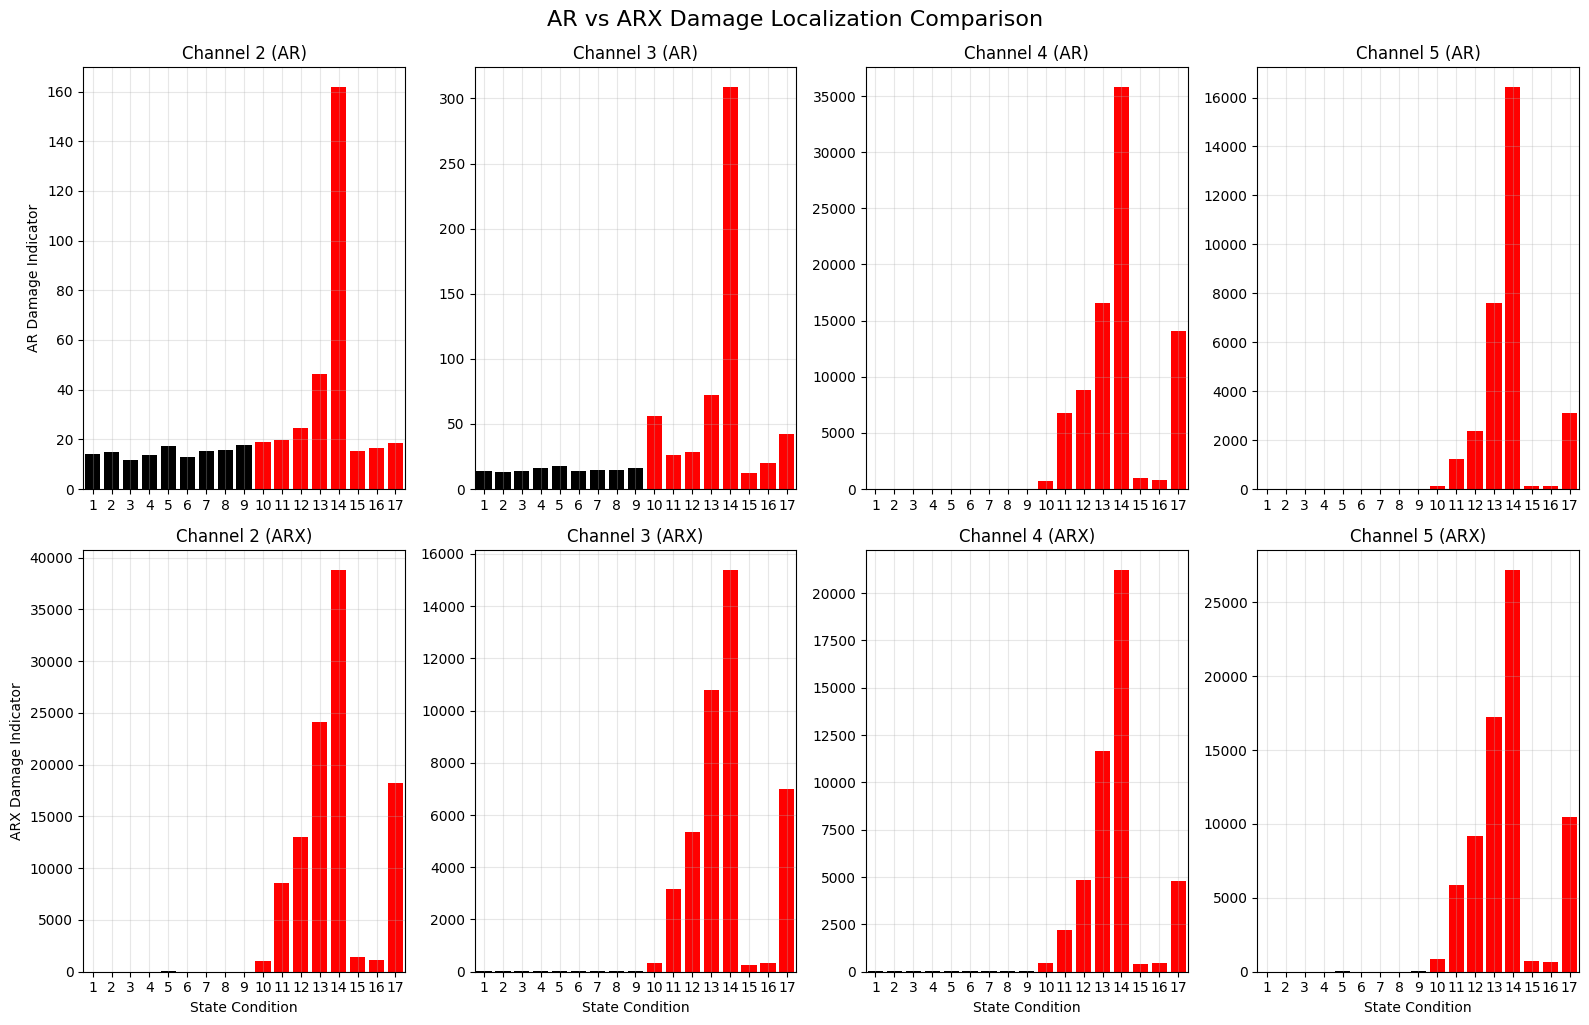

In [16]:
# Create side-by-side comparison plot
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

# AR method plots (top row)
for i in range(4):
    ax = axes[0, i]
    colors = ['k' if j < 9 else 'r' for j in range(17)]
    bars = ax.bar(range(17), ar_damage_indicators[:, i], color=colors)
    ax.set_title(f'{channel_names[i]} (AR)', fontsize=12)
    ax.set_xlim(-0.5, 16.5)
    ax.set_xticks(range(17))
    ax.set_xticklabels(range(1, 18))
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.set_ylabel('AR Damage Indicator')

# ARX method plots (bottom row)
for i in range(4):
    ax = axes[1, i]
    colors = ['k' if j < 9 else 'r' for j in range(17)]
    bars = ax.bar(range(17), arx_damage_indicators[:, i], color=colors)
    ax.set_title(f'{channel_names[i]} (ARX)', fontsize=12)
    ax.set_xlim(-0.5, 16.5)
    ax.set_xticks(range(17))
    ax.set_xticklabels(range(1, 18))
    ax.set_xlabel('State Condition')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.set_ylabel('ARX Damage Indicator')

plt.tight_layout()
plt.suptitle('AR vs ARX Damage Localization Comparison', fontsize=16, y=1.02)
plt.show()

### Sensitivity Improvement Analysis

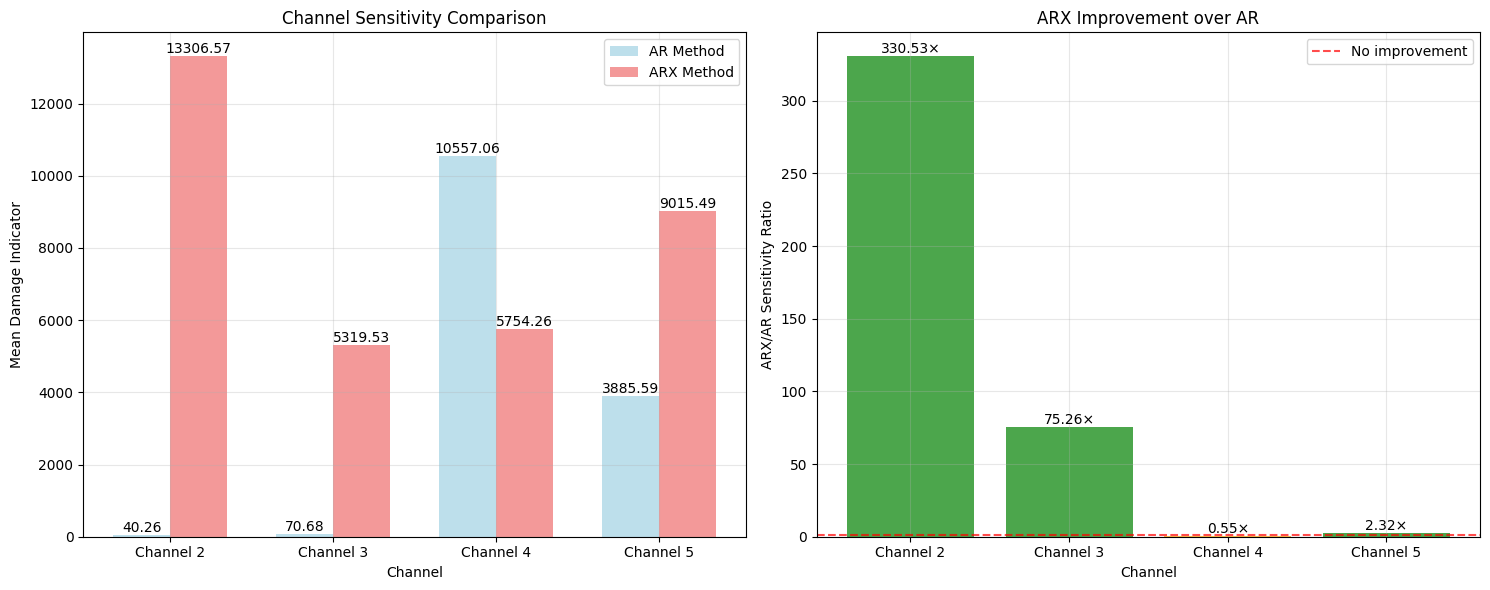

In [17]:
# Plot sensitivity comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sensitivity values comparison
x_pos = np.arange(len(channel_names))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, ar_analysis['channel_sensitivity'], width, 
               label='AR Method', color='lightblue', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, arx_analysis['channel_sensitivity'], width,
               label='ARX Method', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Channel')
ax1.set_ylabel('Mean Damage Indicator')
ax1.set_title('Channel Sensitivity Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(channel_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
             f'{height1:.2f}', ha='center', va='bottom', fontsize=10)
    ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
             f'{height2:.2f}', ha='center', va='bottom', fontsize=10)

# Improvement ratio
improvement_ratio = comparison['sensitivity_ratio']
bars3 = ax2.bar(channel_names, improvement_ratio, 
               color=['green' if r > 1 else 'orange' for r in improvement_ratio],
               alpha=0.7)

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No improvement')
ax2.set_xlabel('Channel')
ax2.set_ylabel('ARX/AR Sensitivity Ratio')
ax2.set_title('ARX Improvement over AR')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for bar, ratio in zip(bars3, improvement_ratio):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{ratio:.2f}×', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Summary and Conclusions

This analysis demonstrates spatial damage localization using both AR and ARX model parameters:

### Key Findings

1. **Damage Localization**: Both methods successfully identify that Channels 4 and 5 are more sensitive to damage than Channels 2 and 3, indicating damage is located closer to the upper floors of the 3-story structure.

2. **AR Method Results**: 
   - Uses only output measurements (accelerations)
   - Provides good discrimination between undamaged and damaged states
   - Simple to implement and interpret

3. **ARX Method Results**:
   - Incorporates input force information
   - Can provide improved damage localization in some cases
   - Captures input-output relationships for better physics-based analysis

### Method Comparison

**AR Model Advantages:**
- Simpler implementation (output-only)
- No need for input measurement
- Robust to input measurement noise
- Faster computation

**ARX Model Advantages:**
- Better physics representation (input-output relationships)
- Potential for improved damage sensitivity
- Input normalization can reduce environmental effects
- Better for systems with known excitation

### Practical Implications

- **Channel-wise analysis** enables spatial damage localization across sensor arrays
- **Mahalanobis distance** provides effective outlier detection for each channel
- **Multiple model comparison** increases confidence in damage localization results
- **Structural knowledge** helps interpret which channels correspond to different structural locations

### Recommendations

1. **For new applications**: Start with AR analysis for simplicity, then consider ARX if input measurements are available
2. **For critical structures**: Use both methods as complementary approaches
3. **For environmental robustness**: Consider ARX models when input forces can be measured
4. **For sensor network design**: Use these results to optimize sensor placement for damage localization